In [95]:
!pip install numpy matplotlib seaborn

In [96]:
import numpy as np 
import matplotlib.pyplot as plt 
bridge_trajs = np.load("assets/bridge_v2_10_trajs.npy", allow_pickle=True)

In [97]:
bridge_trajs[0]['observations'][0].keys()

dict_keys(['images0', 'state', 'time_stamp'])

In [98]:
state_deltas = []
actions = []

STATE_WINDOW = 2

for i, traj in enumerate(bridge_trajs):
    # original implementation tries move_trajs = [states[i : i + 4] for i in range(len(states) - 1)]
    these_states = np.array([obs['state'] for obs in traj['observations']])
    state_chunks = [these_states[i : i + STATE_WINDOW] for i in range(len(these_states) - STATE_WINDOW + 1)]
    
    if i == 0:
        print(state_chunks[0])
    these_state_deltas = np.array([chunk[-1] - chunk[0] for chunk in state_chunks])
    state_deltas.append(np.array(these_state_deltas))

    these_actions = np.array(traj['actions'])
    actions.append(np.array(these_actions))


[[ 0.30876538 -0.06880122  0.13227557 -0.01348165 -0.32143424  0.02157867
   1.00147746]
 [ 0.30885509 -0.0688109   0.13312443 -0.01388107 -0.32292808  0.0218386
   1.00147746]
 [ 0.3085754  -0.06844989  0.12420845 -0.00633715 -0.29783629  0.03479877
   1.00147746]
 [ 0.31148891 -0.08985537  0.12013049 -0.00693817 -0.35101056  0.16110752
   1.00147746]]


In [99]:
stacked_state_deltas = np.concat(state_deltas, axis=0)
stacked_actions = np.concat(actions, axis=0)
print("states: ", stacked_state_deltas.shape)
print("actions: ", stacked_actions.shape)


states:  (384, 7)
actions:  (414, 7)


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the joint descriptions
joint_info = {
    0: ("X-Axis", "Forward (+) / Backward (-)"),
    1: ("Y-Axis", "Left (+) / Right (-)"),
    2: ("Z-Axis", "Up (+) / Down (-)"),
    3: ("Pitch", "Tilt Up (+) / Down (-)"),
    4: ("Roll", "Roll Up (+) / Down (-)"),
    5: ("Yaw", "Rotate CCW (+) / CW (-)"),
    6: ("Gripper", "Open (+) / Close (-)")
}

def plot_joint_distributions(stacked_state_deltas: np.ndarray, stacked_actions: np.ndarray) -> None:
    """
    Plot overlaid distributions of state deltas and actions for each joint.
    
    Args:
        stacked_state_deltas: Array of shape (n_samples, 7) containing state delta values
        stacked_actions: Array of shape (n_samples, 7) containing action values
    """
    # Create a figure with subplots arranged in a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    # Colors for the two distributions
    state_color = '#3498db'  # Blue for states
    action_color = '#e74c3c'  # Red for actions

    # Plot each joint's distribution
    for joint_idx in range(7):
        ax = axes[joint_idx]
        
        # Plot state deltas
        sns.histplot(
            data=stacked_state_deltas[:, joint_idx],
            kde=True,
            ax=ax,
            color=state_color,
            alpha=0.4,
            label='State Deltas',
            stat='density'
        )
        
        # Overlay action distribution
        sns.histplot(
            data=stacked_actions[:, joint_idx],
            kde=True,
            ax=ax,
            color=action_color,
            alpha=0.4,
            label='Actions',
            stat='density'
        )
        
        # Add title and labels
        joint_name, joint_desc = joint_info[joint_idx]
        ax.set_title(f'{joint_name}\n{joint_desc}', fontsize=10)
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        
        # Add legend
        ax.legend()
        
        # Add statistics as text
        state_mean = np.mean(stacked_state_deltas[:, joint_idx])
        state_std = np.std(stacked_state_deltas[:, joint_idx])
        action_mean = np.mean(stacked_actions[:, joint_idx])
        action_std = np.std(stacked_actions[:, joint_idx])
        
        stats_text = (f'States: μ = {state_mean:.3f}, σ = {state_std:.3f}\n'
                     f'Actions: μ = {action_mean:.3f}, σ = {action_std:.3f}')
        
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.8),
                fontsize=8)

    # Remove the unused subplots
    for idx in range(7, 9):
        fig.delaxes(axes[idx])

    plt.suptitle('Robot Joint State and Action Distributions', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Joint Statistics:")
    for joint_idx in range(7):
        joint_name, joint_desc = joint_info[joint_idx]
        state_data = stacked_state_deltas[:, joint_idx]
        action_data = stacked_actions[:, joint_idx]
        
        print(f"\n{joint_name} ({joint_desc}):")
        print("State Deltas:")
        print(f"  Mean: {np.mean(state_data):.3f}")
        print(f"  Std:  {np.std(state_data):.3f}")
        print(f"  Min:  {np.min(state_data):.3f}")
        print(f"  Max:  {np.max(state_data):.3f}")
        print(f"  Median: {np.median(state_data):.3f}")
        
        print("Actions:")
        print(f"  Mean: {np.mean(action_data):.3f}")
        print(f"  Std:  {np.std(action_data):.3f}")
        print(f"  Min:  {np.min(action_data):.3f}")
        print(f"  Max:  {np.max(action_data):.3f}")
        print(f"  Median: {np.median(action_data):.3f}")

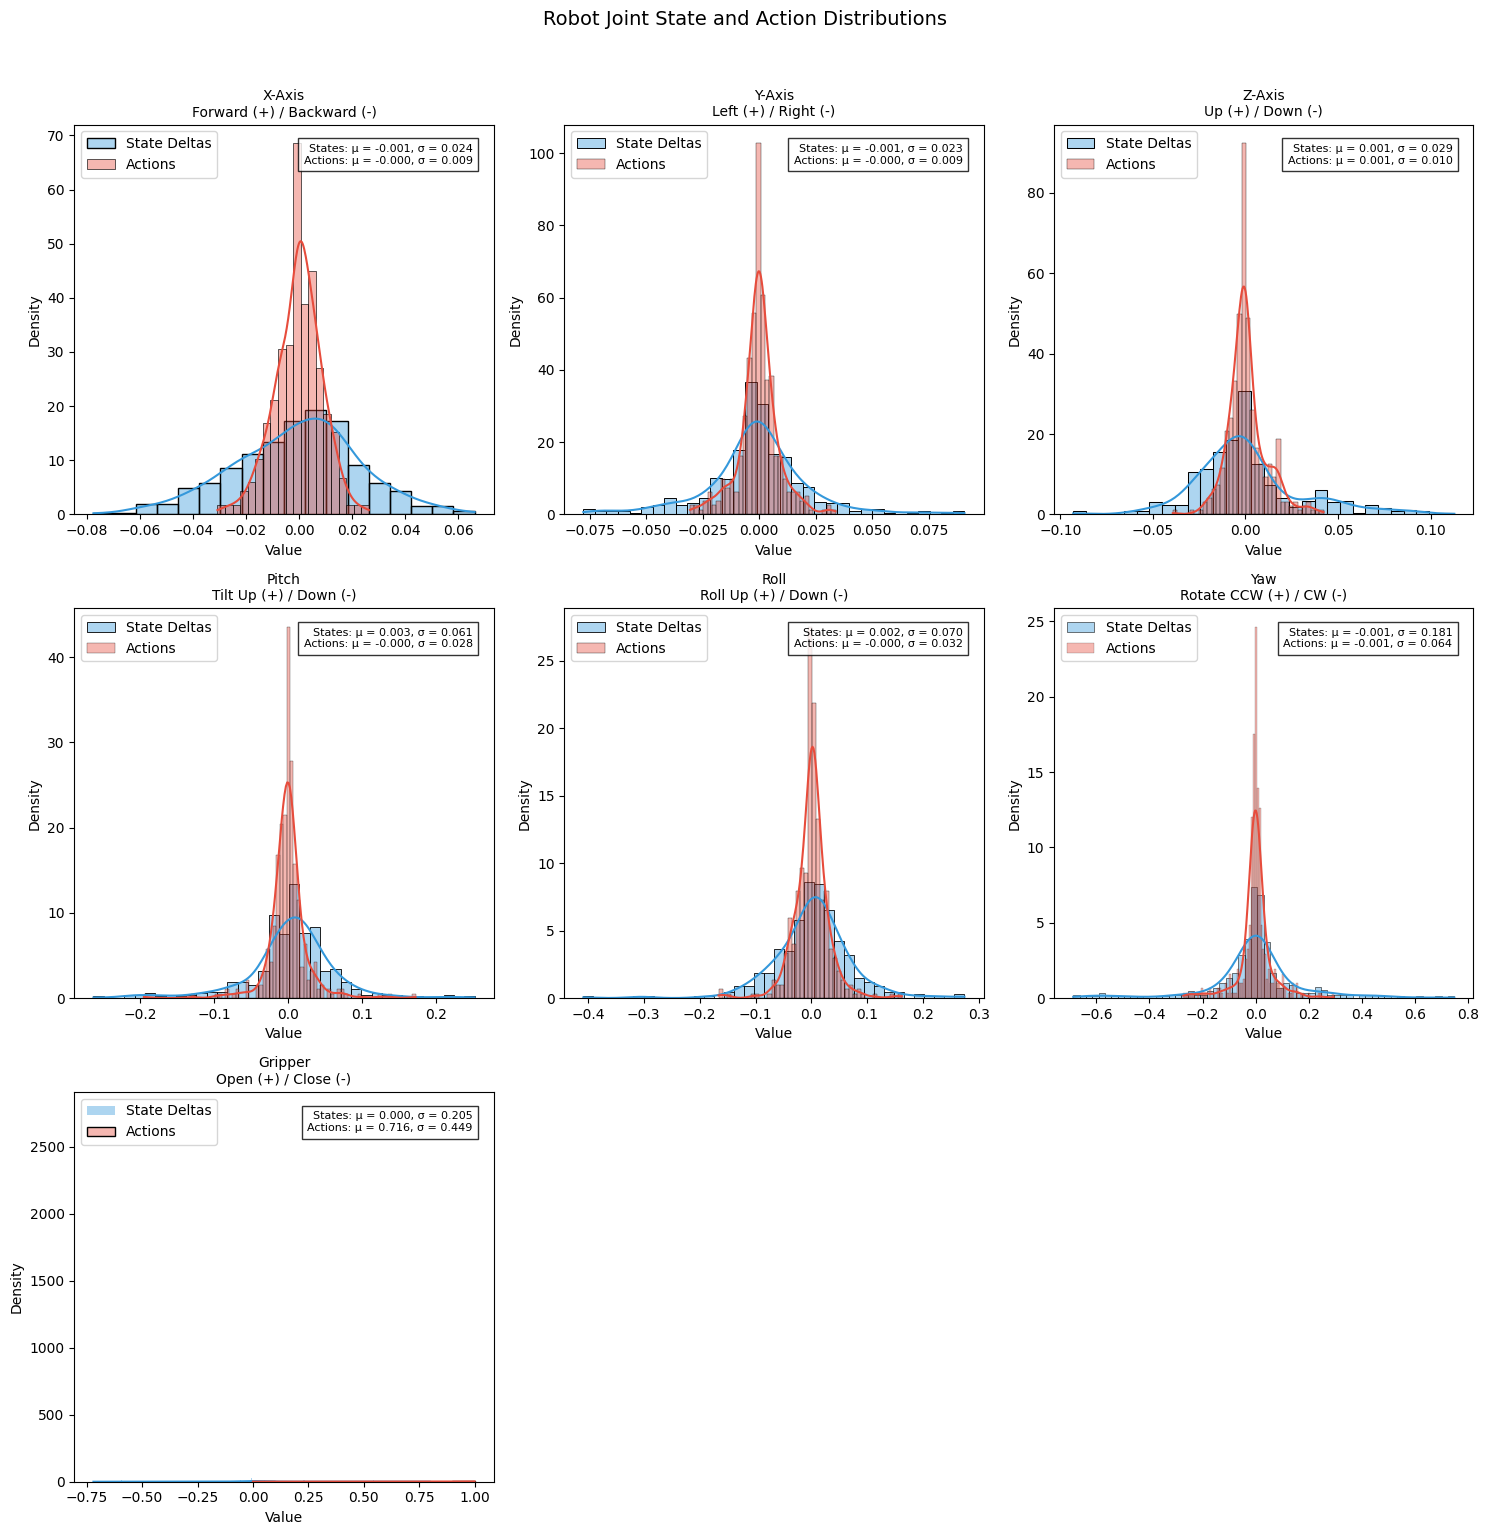


Detailed Joint Statistics:

X-Axis (Forward (+) / Backward (-)):
State Deltas:
  Mean: -0.001
  Std:  0.024
  Min:  -0.078
  Max:  0.066
  Median: 0.001
Actions:
  Mean: -0.000
  Std:  0.009
  Min:  -0.031
  Max:  0.026
  Median: 0.000

Y-Axis (Left (+) / Right (-)):
State Deltas:
  Mean: -0.001
  Std:  0.023
  Min:  -0.078
  Max:  0.091
  Median: -0.001
Actions:
  Mean: -0.000
  Std:  0.009
  Min:  -0.031
  Max:  0.034
  Median: -0.000

Z-Axis (Up (+) / Down (-)):
State Deltas:
  Mean: 0.001
  Std:  0.029
  Min:  -0.093
  Max:  0.113
  Median: -0.002
Actions:
  Mean: 0.001
  Std:  0.010
  Min:  -0.039
  Max:  0.042
  Median: -0.000

Pitch (Tilt Up (+) / Down (-)):
State Deltas:
  Mean: 0.003
  Std:  0.061
  Min:  -0.264
  Max:  0.253
  Median: 0.009
Actions:
  Mean: -0.000
  Std:  0.028
  Min:  -0.195
  Max:  0.173
  Median: 0.000

Roll (Roll Up (+) / Down (-)):
State Deltas:
  Mean: 0.002
  Std:  0.070
  Min:  -0.408
  Max:  0.274
  Median: 0.004
Actions:
  Mean: -0.000
  Std:  0.03

In [101]:
# Example usage
plot_joint_distributions(stacked_state_deltas, stacked_actions)